In [1]:
import pandas as pd
import os
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_data(system_list, header):
    dataframes = []
    for csv_file in filter(lambda x:x.endswith(".csv"), os.listdir(".")):
        #print(csv_file)
        #df = pd.read_csv(csv_file, names= ["Dataset", "Top K", "QTS", "ndcg@10","ndcg@1000","recall@1000","Score QTS", "GPU to CPU"])
        df = pd.read_csv(csv_file, names= header)
        df.insert(0, "System", csv_file[:-4], True)
        #print(len(df.columns))
        #if len(df.columns) == 3:
        #    df.names = ["Dataset", "Top K", "QTS"]
        #else:
        #    df.names = ["Dataset", "Top K", "QTS", "Score QTS", "Mem transference"]
        dataframes.append(df)

    data = pd.concat(dataframes, axis=0, ignore_index=True)
    systems_to_keep = system_list

    return  data[data['System'].isin(systems_to_keep)]



    

In [6]:
def compute_speedup_against(framework):
    _dummy_map = {"pyserini":"pyseniri"}
    
    if framework in _dummy_map:
        _framework = _dummy_map[framework]
    else:
        _framework = framework
    data_se = load_data(['pyseniri', 'pyterrier'], header=["Dataset", "Top K", "QTS","Score QTS", "GPU to CPU"])
    data_se = data_se[data_se["Dataset"]=="beir_datasets/msmarco"][["System", "Top K", "QTS"]]
    
    #print(data_se)
    
    sys_list = [f"sparse_retriever_from_{framework}_devices_cuda:0", 
                   #f"sparse_retriever_from_{framework}_devices_cuda:0_cache_bow", 
                   f"sparse_retriever_from_{framework}_devices_cuda:0_fp_16", 
                   #f"sparse_retriever_from_{framework}_devices_cuda:0_fp_16_cache_bow", 
                   ]

    data_se = data_se[data_se['System'].isin([_framework])]

    data_spare = load_data(sys_list, header=["Dataset", "Top K", "QTS","Score QTS", "GPU to CPU"])

    #topk_list = data_spare['Top K'].unique()

    #print(topk_list.tolist())
    data_view = data_spare[data_spare["Dataset"]=="/data/projects/cpca2254670a0/beir_datasets/msmarco"][["System", "Top K", "QTS", "Score QTS"]]  
    
    #print(data_se)
      
    for system in data_view["System"].unique():
        _view = data_view[data_view["System"]==system]
        data_view.loc[data_view["System"]==system, "QTS speedup"] = _view["QTS"].div(data_se["QTS"].values)
        data_view.loc[data_view["System"]==system, "QTS speedup w mem"] = _view["Score QTS"].div(data_se["QTS"].values)
        
    
        
    return data_view

    

In [9]:
pyterrier_speedup = compute_speedup_against("pyterrier")



In [10]:
pyserini_speedup = compute_speedup_against("pyserini")



In [11]:
pyterrier_speedup

,System,Top K,QTS,Score QTS,QTS speedup,QTS speedup w mem
110,sparse_retriever_from_pyterrier_devices_cuda:0_fp_16,10,210.125963,224.555736,6.533930,6.982628
111,sparse_retriever_from_pyterrier_devices_cuda:0_fp_16,100,215.042821,227.678371,8.597454,9.102626
112,sparse_retriever_from_pyterrier_devices_cuda:0_fp_16,1000,200.509113,211.474208,24.763615,26.117845
113,sparse_retriever_from_pyterrier_devices_cuda:0_fp_16,10000,203.375108,217.225233,151.440528,161.753837
138,sparse_retriever_from_pyterrier_devices_cuda:0,10,196.614208,221.518655,6.113778,6.888189
139,sparse_retriever_from_pyterrier_devices_cuda:0,100,211.638504,227.349162,8.461349,9.089464
140,sparse_retriever_from_pyterrier_devices_cuda:0,1000,205.506288,217.620198,25.380785,26.876897
141,sparse_retriever_from_pyterrier_devices_cuda:0,10000,204.243824,219.555022,152.087405,163.488683


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


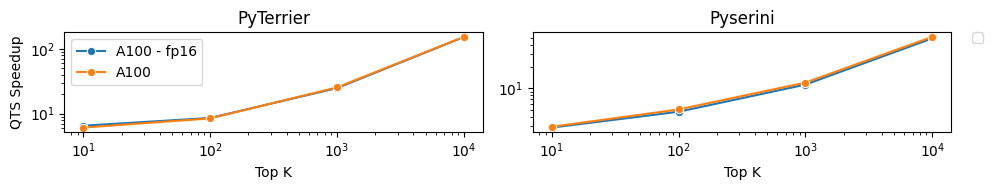

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(10, 2))

pyterrier_replacement_labels = {"sparse_retriever_from_pyterrier_devices_cuda:0_fp_16": "A100 - fp16",
                                "sparse_retriever_from_pyterrier_devices_cuda:0": "A100",}

pyserini_replacement_labels = {"sparse_retriever_from_pyserini_devices_cuda:0_fp_16": "A100 - fp16",
                                "sparse_retriever_from_pyserini_devices_cuda:0": "A100",}

for old_label, new_label in pyterrier_replacement_labels.items():
    pyterrier_speedup['System'] = pyterrier_speedup['System'].replace(old_label, new_label)

for old_label, new_label in pyserini_replacement_labels.items():
    pyserini_speedup['System'] = pyserini_speedup['System'].replace(old_label, new_label)

for i, data in enumerate([pyterrier_speedup, pyserini_speedup]):
    _legend=False
    if i==1:
        _legend = True
    sns.lineplot(data=data, x='Top K', y='QTS speedup', hue='System', marker='o', ax=axes[i], legend=(i==0))

    # Settings for better visualization
    axes[i].set_yscale('log')
    #axes[i].set_xscale('log')  # Because your Top K values increase exponentially
    axes[i].set_title('QTS Speedup vs Top K for different Systems')
    #axes[i].set_ylabel('QTS Speedup')
    axes[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    axes[i].set_xlabel('Top K')

    if i == 0:
        axes[i].set_ylabel('QTS Speedup')
        axes[i].set_title('PyTerrier')
    else:
        axes[i].set_ylabel('')
        axes[i].set_title('Pyserini')
        
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles=handles, labels=labels, loc='best')

plt.tight_layout()
plt.show()
    

In [10]:

data_view["QTS"]

38    331.742535
39    331.086683
40    325.340100
41    312.207678
Name: QTS, dtype: float64

In [ ]:
data_view["QTS speedup"] = data_view["QTS"] / data_se["QTS"]

In [5]:
data_view["QTS"] / data_se["QTS"]

38   NaN
39   NaN
40   NaN
41   NaN
86   NaN
87   NaN
88   NaN
89   NaN
Name: QTS, dtype: float64

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# pivot_data = data.pivot_table(values='QTS', index='System', columns='Top K')
datasets = data['Dataset'].unique()

systems_to_keep = ['pyseniri', #pyserini
                   'pyterrier', 
                   "sparse_retriever_from_pyserini_devices_cpu", 
                   "sparse_retriever_from_pyterrier_devices_cpu",
                   "sparse_retriever_from_pyserini_devices_cuda:0", 
                   "sparse_retriever_from_pyterrier_devices_cuda:0",]
data = data[data['System'].isin(systems_to_keep)]


# Plot for each dataset
for dataset in datasets:
    plt.figure(figsize=(14, 7))
    
    # Filter the data for the specific dataset
    subset_data = data[data['Dataset'] == dataset]
    
    sns.lineplot(x='Top K', y='QTS', hue='System', data=subset_data, marker='o', dashes=False, markersize=6)
    sns.scatterplot(x='Top K', y='QTS', hue='System', data=subset_data, legend=False)
    plt.xscale('log')
    plt.title(f'QTS by top_k for Dataset: {dataset}')
    plt.legend(title='System')
    plt.tight_layout()
    plt.show()


In [8]:
grouped = data.groupby(['System', 'Top K', 'Dataset'])#['QTS'].mean().reset_index()
grouped

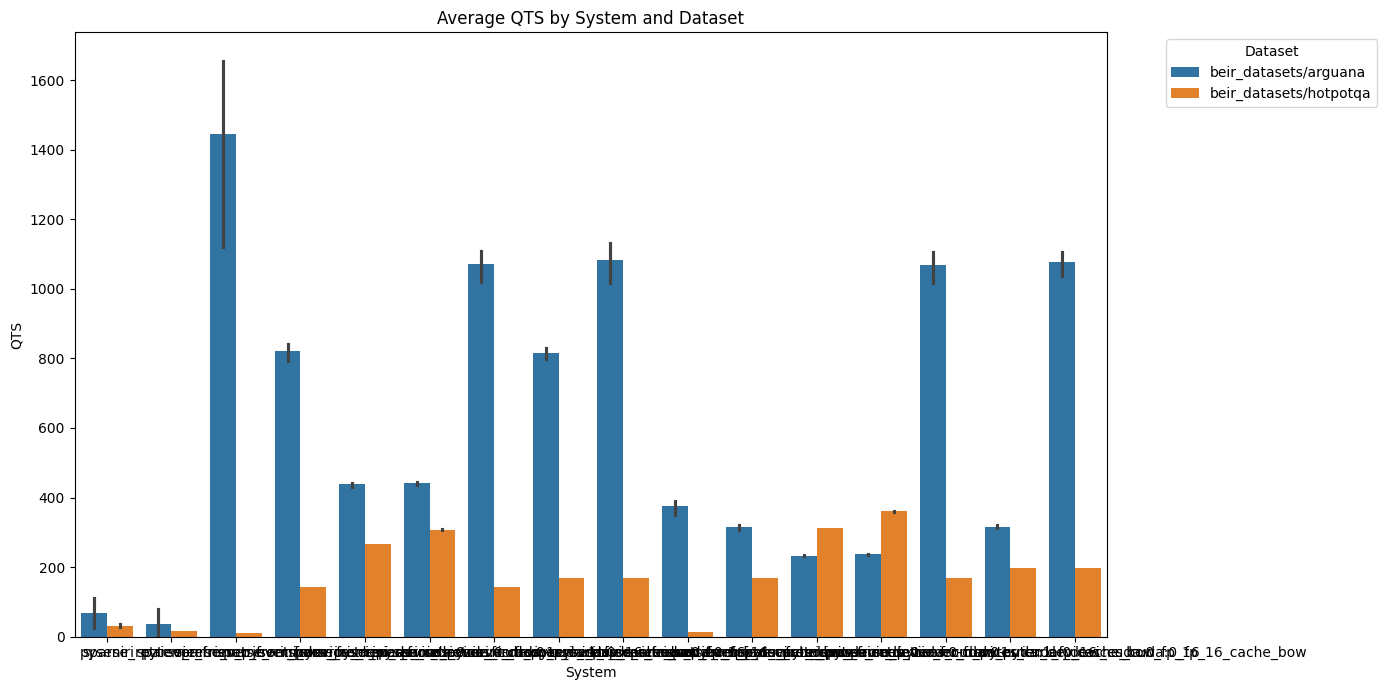

In [52]:
plt.figure(figsize=(14, 7))
sns.barplot(x='System', y='QTS', hue='Dataset', data=grouped)
plt.title('Average QTS by System and Dataset')
plt.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()